In [1]:
# Cell 1 — basic imports & device
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
# Cell 2 — build an imbalanced-by-wbflag subset from MNIST_subset
import os
import numpy as np

SEED = 12345
DIGITS_TO_KEEP = [0, 4, 3]        # keep only these digits

# ---- Imbalance controls ----
N_PER_DIGIT_TOTAL = 400           # total samples per digit (wbflag=0 + wbflag=1)
FLAG1_RATIO = 0.30                # fraction of wbflag=1 (inverted) per digit (e.g., 0.2 -> 20%)

in_dir  = "datasets/MNIST/MNIST_subset"
out_dir = f"datasets/MNIST/MNIST_subset_{'_'.join(map(str, DIGITS_TO_KEEP))}_" \
          f"{len(DIGITS_TO_KEEP)*N_PER_DIGIT_TOTAL}_imb{int(FLAG1_RATIO*100)}"
os.makedirs(out_dir, exist_ok=True)

X_full = np.load(os.path.join(in_dir, "MNIST_train_wbX.npy"))     # (N,784) or (N,28,28)
digits = np.load(os.path.join(in_dir, "MNIST_train_digits.npy"))
wbflag = np.load(os.path.join(in_dir, "MNIST_train_wbflag.npy"))

rng = np.random.default_rng(SEED)
selected_indices = []

# precompute target counts per flag
target_n1 = int(round(N_PER_DIGIT_TOTAL * FLAG1_RATIO))     # wbflag=1
target_n0 = N_PER_DIGIT_TOTAL - target_n1                   # wbflag=0

for d in DIGITS_TO_KEEP:
    picks_for_d = []

    for f, target_n in [(0, target_n0), (1, target_n1)]:
        mask = (digits == d) & (wbflag == f)
        idxs = np.where(mask)[0]
        rng.shuffle(idxs)

        if len(idxs) < target_n:
            print(f"[WARN] digit={d}, wbflag={f}: requested {target_n}, "
                  f"but only {len(idxs)} available. Taking all available.")
        take = min(len(idxs), target_n)
        picks_for_d.extend(idxs[:take])

    # If one flag was short, optionally top-up from the other flag to still hit N_PER_DIGIT_TOTAL
    # Comment this block out if you prefer to keep the *exact* imbalance even when under-sampling occurs.
    if len(picks_for_d) < N_PER_DIGIT_TOTAL:
        need = N_PER_DIGIT_TOTAL - len(picks_for_d)
        # try topping up from whichever flag still has remaining samples
        for f in (0, 1):
            if need == 0: break
            mask = (digits == d) & (wbflag == f)
            pool = np.setdiff1d(np.where(mask)[0], np.array(picks_for_d), assume_unique=False)
            rng.shuffle(pool)
            extra = min(need, len(pool))
            if extra > 0:
                picks_for_d.extend(pool[:extra])
                need -= extra

    rng.shuffle(picks_for_d)
    selected_indices.extend(picks_for_d[:N_PER_DIGIT_TOTAL])  # enforce per-digit cap

selected_indices = np.array(selected_indices)
rng.shuffle(selected_indices)

digits_sub = digits[selected_indices]         # true digits, e.g., {0,3,4}
wbflag_sub = wbflag[selected_indices]         # sensitive flag {0 (orig), 1 (inverted)}
X_sub_full = X_full[selected_indices]         # images

# group = true digit (kept for analysis if needed)
group_sub = digits_sub.copy()

np.save(os.path.join(out_dir, "digits.npy"),  digits_sub)
np.save(os.path.join(out_dir, "wbflag.npy"),  wbflag_sub)
np.save(os.path.join(out_dir, "group.npy"),   group_sub)
np.save(os.path.join(out_dir, "indices.npy"), selected_indices)
np.save(os.path.join(out_dir, "wbX.npy"),     X_sub_full)

# Flatten if needed
if X_sub_full.ndim == 3:
    X_points = X_sub_full.reshape(X_sub_full.shape[0], -1).astype(np.float32)
else:
    X_points = X_sub_full.astype(np.float32)

# y_raw: original labels in DIGITS_TO_KEEP
y_raw = digits_sub.astype(np.int64)

# y: remap to {0,1,2} for CE if you ever need it
unique_labels = np.array(sorted(np.unique(y_raw)))  # e.g., [0,3,4]
label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}
y = np.vectorize(label_to_idx.get)(y_raw).astype(np.int64)

np.save(os.path.join(out_dir, "X.npy"),      X_points)
np.save(os.path.join(out_dir, "y_raw.npy"),  y_raw)
np.save(os.path.join(out_dir, "y.npy"),      y)

# Quick counts
print(f"\nTarget per digit: wbflag=0 -> {target_n0}, wbflag=1 -> {target_n1} "
      f"(total {N_PER_DIGIT_TOTAL}, ratio flag1={FLAG1_RATIO:.2f})")

for d in DIGITS_TO_KEEP:
    for f in (0, 1):
        c = np.sum((digits_sub == d) & (wbflag_sub == f))
        print(f"(digit={d}, wbflag={f}): {c}")

print("\nRemapped classes (0,1,2):")
for k, lab in enumerate(unique_labels):
    print(f"class {k} (digit {lab}): {(y==k).sum()}")

print("\nShapes:")
print("X_points:", X_points.shape, "| y_raw:", y_raw.shape, "| y:", y.shape)



Target per digit: wbflag=0 -> 280, wbflag=1 -> 120 (total 400, ratio flag1=0.30)
(digit=0, wbflag=0): 280
(digit=0, wbflag=1): 120
(digit=4, wbflag=0): 280
(digit=4, wbflag=1): 120
(digit=3, wbflag=0): 280
(digit=3, wbflag=1): 120

Remapped classes (0,1,2):
class 0 (digit 0): 400
class 1 (digit 3): 400
class 2 (digit 4): 400

Shapes:
X_points: (1200, 784) | y_raw: (1200,) | y: (1200,)


In [3]:
# Cell 2 — build a subset from MNIST_subset
import os
import numpy as np

SEED = 12345
N_PER_DIGIT_FLAG = 200          # per (digit, flag), flag=0 original, flag=1 inverted
DIGITS_TO_KEEP = [0, 4, 3]      # keep only these digits

in_dir  = "datasets/MNIST/MNIST_subset"
out_dir = f"datasets/MNIST/MNIST_subset_{'_'.join(map(str, DIGITS_TO_KEEP))}_{len(DIGITS_TO_KEEP)*2*N_PER_DIGIT_FLAG}"
os.makedirs(out_dir, exist_ok=True)

X_full = np.load(os.path.join(in_dir, "MNIST_train_wbX.npy"))     # (N,784) or (N,28,28)
digits = np.load(os.path.join(in_dir, "MNIST_train_digits.npy"))
wbflag = np.load(os.path.join(in_dir, "MNIST_train_wbflag.npy"))

rng = np.random.default_rng(SEED)
selected_indices = []

for d in DIGITS_TO_KEEP:
    for f in (0, 1):  # original & inverted
        mask = (digits == d) & (wbflag == f)
        idxs = np.where(mask)[0]
        rng.shuffle(idxs)
        selected_indices.extend(idxs[:N_PER_DIGIT_FLAG])

selected_indices = np.array(selected_indices)
rng.shuffle(selected_indices)

digits_sub = digits[selected_indices]         # true digits {0,3,4}
wbflag_sub = wbflag[selected_indices]         # sensitive flag {0,1}
X_sub_full = X_full[selected_indices]         # images

# group = true digit (kept for analysis if needed)
group_sub = digits_sub.copy()

np.save(os.path.join(out_dir, "digits.npy"),  digits_sub)
np.save(os.path.join(out_dir, "wbflag.npy"),  wbflag_sub)
np.save(os.path.join(out_dir, "group.npy"),   group_sub)
np.save(os.path.join(out_dir, "indices.npy"), selected_indices)
np.save(os.path.join(out_dir, "wbX.npy"),     X_sub_full)

# Flatten if needed
if X_sub_full.ndim == 3:
    X_points = X_sub_full.reshape(X_sub_full.shape[0], -1).astype(np.float32)
else:
    X_points = X_sub_full.astype(np.float32)

# y_raw: original labels in {0,3,4}
y_raw = digits_sub.astype(np.int64)

# y: remap to {0,1,2} for CE if you ever need it
unique_labels = np.array(sorted(np.unique(y_raw)))  # e.g. [0,3,4]
label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}
y = np.vectorize(label_to_idx.get)(y_raw).astype(np.int64)

np.save(os.path.join(out_dir, "X.npy"),      X_points)
np.save(os.path.join(out_dir, "y_raw.npy"),  y_raw)
np.save(os.path.join(out_dir, "y.npy"),      y)

# Quick counts
for d in DIGITS_TO_KEEP:
    for f in (0, 1):
        c = np.sum((digits_sub == d) & (wbflag_sub == f))
        print(f"(digit={d}, wbflag={f}): {c}")

print("\nRemapped classes (0,1,2):")
for k, lab in enumerate(unique_labels):
    print(f"class {k} (digit {lab}): {(y==k).sum()}")

print("\nShapes:")
print("X_points:", X_points.shape, "| y_raw:", y_raw.shape, "| y:", y.shape)


(digit=0, wbflag=0): 200
(digit=0, wbflag=1): 200
(digit=4, wbflag=0): 200
(digit=4, wbflag=1): 200
(digit=3, wbflag=0): 200
(digit=3, wbflag=1): 200

Remapped classes (0,1,2):
class 0 (digit 0): 400
class 1 (digit 3): 400
class 2 (digit 4): 400

Shapes:
X_points: (1200, 784) | y_raw: (1200,) | y: (1200,)


In [4]:
# Cell 3 — lock CUDA device (optional)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.set_device(device)

print(f"Using device: {device}")


Using device: cpu


In [5]:
# Cell 4 — dataloader returning (X, y, S)
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def load_subset_with_wbflag(subset_dir, batch_size=256, shuffle=True):
    X = np.load(os.path.join(subset_dir, "X.npy")).astype(np.float32)     # (N, D)
    y = np.load(os.path.join(subset_dir, "y.npy")).astype(np.int64)       # (N,)
    S = np.load(os.path.join(subset_dir, "wbflag.npy")).astype(np.int64)  # (N,) 0=orig,1=inv
    assert len(X) == len(y) == len(S)

    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.long)
    S_t = torch.tensor(S, dtype=torch.long)

    ds = TensorDataset(X_t, y_t, S_t)   # returns (X, y, S)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=shuffle)
    input_dim = X.shape[1]
    return dl, input_dim, X, y, S

# build the dataloader from the subset created in Cell 2
dataloader_wb, input_dim_from_loader, X_np, y_np, S_np = load_subset_with_wbflag(out_dir, batch_size=256, shuffle=True)
print("input_dim_from_loader:", input_dim_from_loader, "| dataset size:", len(X_np))


input_dim_from_loader: 784 | dataset size: 1200


In [6]:
class Autoencoder(nn.Module):
    """Plain AE: encoder -> decoder (no classifier head)."""
    def __init__(self, input_dim: int, latent_dim: int, negative_slope: float = 0.01):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 500),  nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, 500),        nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, 2000),       nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(2000, latent_dim),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2000), nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(2000, 500),        nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, 500),         nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


In [7]:
def pretrain_autoencoder(dataloader, input_dim, latent_dim, device, epochs=30, lr=1e-3):
    ae = Autoencoder(input_dim, latent_dim).to(device)
    opt = optim.Adam(ae.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for ep in range(epochs):
        total = 0
        nobs = 0
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                xb = batch[0]
            else:
                xb = batch
            xb = xb.to(device).float()

            opt.zero_grad(set_to_none=True)
            x_hat, _ = ae(xb)
            loss = loss_fn(x_hat, xb)
            loss.backward()
            opt.step()

            bs = xb.size(0)
            total += loss.item() * bs
            nobs  += bs
        print(f"Pretrain epoch {ep+1}/{epochs} | loss={total/nobs:.6f}")
    return ae


In [8]:
@torch.no_grad()
def init_kmeans_centers_from_latent(ae, dataloader, device, k: int):
    """Run KMeans on current latent to initialize centers."""
    ae.eval()
    Z = []
    for batch in dataloader:
        xb = batch[0] if isinstance(batch, (list, tuple)) else batch
        xb = xb.to(device).float()
        _, z = ae(xb)
        Z.append(z.cpu())
    Z = torch.cat(Z, dim=0).numpy()
    km = KMeans(n_clusters=k, n_init=3, random_state=0).fit(Z)
    centers = torch.tensor(km.cluster_centers_, dtype=torch.float32, device=device, requires_grad=True)
    return torch.nn.Parameter(centers)

In [9]:

@torch.no_grad()
def torch_kmeans_cost_full_stream(ae, centers, dataloader, device, reduce: str = "mean"):

    ae.eval()
    centers = centers.to(device)

    total, nobs = 0.0, 0
    for batch in dataloader:
        xb = batch[0] if isinstance(batch, (list, tuple)) else batch
        xb = xb.to(device).float()
        _, z = ae(xb)                           # [B, D]
        d2 = torch.cdist(z, centers).pow(2)     # [B, K]
        mins = d2.min(dim=1).values             # [B,]

        if reduce == "sum":
            total += mins.sum().item()
        else:  # 'mean' -> θα επιστρέψουμε global mean
            total += mins.sum().item()
            nobs  += mins.numel()

    if reduce == "sum":
        return total
    else:
        loss = total / max(1, nobs)
        return loss


In [19]:
@torch.enable_grad()
def social_fair_dataset(ae, centers, dataloader, device, eps=1e-12):
    """
    Social Fair objective (dataset-level; hard partition):
      Φ_social = max{ Δ(C, U∩A)/|A|,  Δ(C, U∩B)/|B| },
    where Δ(C, U∩A) = sum_j sum_{x∈U_j∩A} ||z - c_j||^2.
    Returns: scalar with grad + (muA, muB) for logging.
    """
    ae.train()
    sumA = torch.zeros((), device=device)
    sumB = torch.zeros((), device=device)
    nA = 0
    nB = 0

    for batch in dataloader:
        xb = batch[0].to(device).float()
        S  = batch[-1].to(device).long()

        x_hat, z = ae(xb)

        # hard assignments: a_i = argmin_j ||z-c_j||^2
        d2 = torch.cdist(z, centers).pow(2)     # (B,K)
        a  = d2.argmin(dim=1)                   # (B,)
        d2_assigned = (z - centers[a]).pow(2).sum(dim=1)  # (B,)

        A = (S == 1)
        B = ~A
        if A.any():
            sumA = sumA + d2_assigned[A].sum()
            nA  += int(A.sum().item())
        if B.any():
            sumB = sumB + d2_assigned[B].sum()
            nB  += int(B.sum().item())

    muA = sumA / (nA + eps) if nA > 0 else torch.zeros((), device=device)
    muB = sumB / (nB + eps) if nB > 0 else torch.zeros((), device=device)
    social = torch.maximum(muA, muB)  # hard max
    return social, muA, muB

In [21]:
@torch.enable_grad()
def separation_fair_dataset(ae, centers, dataloader, device, eps=1e-12):
    """
    Separation Fair objective (dataset-level):
      Φ_sep = min{ E_A[d^2_bisector], E_B[d^2_bisector] },
    where d^2_bisector is squared distance of z to the bisector between its
    nearest and 2nd-nearest centers.
    Returns: scalar with grad + (muA, muB) for logging.
    """
    ae.train()
    sumA = torch.zeros((), device=device)
    sumB = torch.zeros((), device=device)
    nA = 0
    nB = 0

    for batch in dataloader:
        xb = batch[0].to(device).float()
        S  = batch[-1].to(device).long()

        x_hat, z = ae(xb)

        d2 = torch.cdist(z, centers).pow(2)          # (B,K)
        m1_idx = d2.argmin(dim=1)
        d2_mask = d2.scatter(1, m1_idx.unsqueeze(1), float('inf'))
        m2_idx = d2_mask.argmin(dim=1)

        m1 = centers[m1_idx]
        m2 = centers[m2_idx]
        m  = 0.5 * (m1 + m2)
        v  = m2 - m1
        vn = torch.clamp(torch.linalg.norm(v, dim=1, keepdim=True), min=1e-12)
        vhat = v / vn
        s  = ((z - m) * vhat).sum(dim=1)             # signed distance to bisector
        d2_hp = s * s

        A = (S == 1)
        B = ~A
        if A.any():
            sumA = sumA + d2_hp[A].sum()
            nA  += int(A.sum().item())
        if B.any():
            sumB = sumB + d2_hp[B].sum()
            nB  += int(B.sum().item())

    muA = sumA / (nA + eps) if nA > 0 else torch.zeros((), device=device)
    muB = sumB / (nB + eps) if nB > 0 else torch.zeros((), device=device)
    sep = torch.minimum(muA, muB)  # hard min
    return sep, muA, muB

In [23]:
def train_deepclust_seperation(
    ae, dataloader, device, input_dim, latent_dim, k=3,
    epochs=50, lr=1e-3,
    alpha=0.1,        # recon weight
    beta=1.0,         # compactness weight (hard k-means)
    gamma_sep=1.0,    # separation fairness (maximize min bisector dist)
    clip_grad=5.0
):
    """
    Per-epoch:
      Phase 1 (mini-batch): optimize α*MSE + β*compactness
      Phase 2 (full dataset): optimize γ_social*Social  - γ_sep*Separation
    Returns the trained AE, the learnable centers, and a history dict.
    """
    ae = ae.to(device)
    mse = nn.MSELoss()

    # (a) init centers from current latent
    centers = init_kmeans_centers_from_latent(ae, dataloader, device, k)

    # (b) optimizer (AE + centers)
    opt = optim.AdamW(
        [{"params": ae.parameters(), "lr": lr},
         {"params": [centers],       "lr": lr * 0.3}],
        weight_decay=1e-4
    )

    history = {
        "total": [], "rec": [], "cmp": [],
        "social": [], "sep": [],
        "muA_social": [], "muB_social": [],
        "muA_sep": [],    "muB_sep": []
    }

    for ep in range(epochs):
        # ---------- Phase 1: per-batch recon + compactness ----------
        ae.train()
        tot = rec_tot = cmp_tot = 0.0
        nobs = 0

        for batch in dataloader:
            xb = batch[0].to(device).float()

            x_hat, z = ae(xb)

            # reconstruction (input space)
            rec_loss = mse(x_hat, xb)

            # compactness (hard k-means on latent)
            d2 = torch.cdist(z, centers).pow(2)
            min_d2 = d2.min(dim=1).values
            cmp_loss = min_d2.mean()

            loss_phase1 = alpha * rec_loss + beta * cmp_loss

            opt.zero_grad(set_to_none=True)
            loss_phase1.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(ae.parameters(), clip_grad)
            opt.step()

            bs = xb.size(0)
            nobs    += bs
            rec_tot += rec_loss.item() * bs
            cmp_tot += cmp_loss.item() * bs
            tot     += loss_phase1.item() * bs

        rec_epoch = rec_tot / nobs
        cmp_epoch = cmp_tot / nobs
        total_epoch = tot / nobs

        # ---------- Phase 2: FULL-dataset fairness step ----------
        opt.zero_grad(set_to_none=True)

        social_term, muA_soc, muB_soc = social_fair_dataset(ae, centers, dataloader, device)
        sep_term,    muA_sep, muB_sep = separation_fair_dataset(ae, centers, dataloader, device)

        # NOTE: Social is minimized; Separation is maximized -> subtract sep
        fairness_loss = -gamma_sep * sep_term
        fairness_loss.backward()
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(ae.parameters(), clip_grad)
        opt.step()

        # ---------- logging ----------
        history["total"].append(total_epoch + fairness_loss.item())
        history["rec"].append(rec_epoch)
        history["cmp"].append(cmp_epoch)
        history["social"].append(social_term.item())
        history["sep"].append(sep_term.item())
        history["muA_social"].append(muA_soc.item())
        history["muB_social"].append(muB_soc.item())
        history["muA_sep"].append(muA_sep.item())
        history["muB_sep"].append(muB_sep.item())

        print(f"[{ep+1:02d}/{epochs}] "
              f"Rec={rec_epoch:.5f} | Cmp={cmp_epoch:.5f} | "
              f"Social(max)={social_term.item():.5f} | Sep(min)={sep_term.item():.5f} | "
              f"μA_social={muA_soc.item():.5f} μB_social={muB_soc.item():.5f} | "
              f"μA_seperation={muA_sep.item():.5f} μB_seperation={muB_sep.item():.5f}")

    return ae, centers, history

In [25]:
# === Patch the grid runner to collect decoded centers (L, S, K, D) ===
import numpy as np
import torch, copy
from pathlib import Path

def run_lambda_seed_grid(
    ae_pretrained,              # pretrained AE (weights used as reset point)
    dataloader_wb,              # must return (X, y, S)
    device,
    latent_dim=20,
    k=3,
    epochs=50,
    lr=0.01,
    alpha=1.0,
    beta=1.0,
    lambda_list=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0),
    seeds=range(10),
    save_dir="centroids_deep",
    save_centers_files=True,
    collect_decoded_centers=True,   # <— NEW
):
    # metric holders
    min_fair_dict = {lam: [] for lam in lambda_list}
    max_fair_dict = {lam: [] for lam in lambda_list}
    seperation_fairness_gaps  = {lam: [] for lam in lambda_list}
    social_fairness_gaps  = {lam: [] for lam in lambda_list}
    kmeans_costs   = {lam: [] for lam in lambda_list}
    recon_costs    = {lam: [] for lam in lambda_list}
    compact_costs  = {lam: [] for lam in lambda_list}

    # figure out input_dim (D) once from the dataloader
    first_batch = next(iter(dataloader_wb))
    X_first = first_batch[0] if isinstance(first_batch, (list, tuple)) else first_batch
    D = X_first.shape[1]

    # decoded centers holder: (L, S, K, D)
    decoded_centers = None
    if collect_decoded_centers:
        L = len(lambda_list); S = len(list(seeds))
        decoded_centers = np.zeros((L, S, k, D), dtype=np.float32)

    # reset AE from the same pretrained weights per run
    pretrained_state = copy.deepcopy(ae_pretrained.state_dict())

    for li, lam in enumerate(lambda_list):
        print(f"\n=== λ (gamma) = {lam} ===")
        for si, seed in enumerate(seeds):
            print(f"  -> seed {seed}")
            np.random.seed(seed)
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

            # fresh AE copy from the same pretrained weights
            ae = copy.deepcopy(ae_pretrained).to(device)
            ae.load_state_dict(pretrained_state)

            # train joint for this (lambda, seed)
            ae, centers, history = train_deepclust_seperation(
                ae, dataloader_wb, device,input_dim=input_dim, 
                latent_dim=latent_dim, k=k,
                lr=lr, epochs=epochs,
                alpha=alpha, beta=beta,gamma_sep=lam
            )
            # final metrics over FULL dataset
            kmeans_cost = torch_kmeans_cost_full_stream(ae, centers, dataloader_wb, device,reduce="sum")
            minFair,cfdA, cfdB = separation_fair_dataset(ae, centers, dataloader_wb, device, eps=1e-12)
            maxFair,muA,muB= social_fair_dataset(ae, centers, dataloader_wb, device, eps=1e-12)
            seperation_gap = abs(cfdA - cfdB)
            social_gap = abs(muA - muB)

            kmeans_costs[lam].append(kmeans_cost)
            min_fair_dict[lam].append(minFair)
            max_fair_dict[lam].append(maxFair)
            seperation_fairness_gaps[lam].append(seperation_gap)
            social_fairness_gaps[lam].append(social_gap)
            recon_costs[lam].append(history["rec"][-1])
            compact_costs[lam].append(history["cmp"][-1])

    results = {
        "min_fair": min_fair_dict,
        "max_fair": max_fair_dict,
        "seperation_fair_gap": seperation_fairness_gaps,
        "social_fair_gap": social_fairness_gaps,
        "kmeans": kmeans_costs,
        "rec": recon_costs,
        "cmp": compact_costs
    }
    # Return decoded centers alongside results
    return results, list(lambda_list)


In [27]:
first_batch = next(iter(dataloader_wb))
X0 = first_batch[0] if isinstance(first_batch, (list, tuple)) else first_batch
input_dim = X0.shape[1]

latent_dim = 20
k = 3
ae = pretrain_autoencoder(dataloader_wb, input_dim, latent_dim=20, device=device, epochs=50)

Pretrain epoch 1/50 | loss=0.374170
Pretrain epoch 2/50 | loss=0.128439
Pretrain epoch 3/50 | loss=0.105911
Pretrain epoch 4/50 | loss=0.081358
Pretrain epoch 5/50 | loss=0.073404
Pretrain epoch 6/50 | loss=0.071645
Pretrain epoch 7/50 | loss=0.070216
Pretrain epoch 8/50 | loss=0.069377
Pretrain epoch 9/50 | loss=0.068927
Pretrain epoch 10/50 | loss=0.068564
Pretrain epoch 11/50 | loss=0.067989
Pretrain epoch 12/50 | loss=0.067197
Pretrain epoch 13/50 | loss=0.066303
Pretrain epoch 14/50 | loss=0.065838
Pretrain epoch 15/50 | loss=0.065300
Pretrain epoch 16/50 | loss=0.064845
Pretrain epoch 17/50 | loss=0.064448
Pretrain epoch 18/50 | loss=0.064038
Pretrain epoch 19/50 | loss=0.063625
Pretrain epoch 20/50 | loss=0.063080
Pretrain epoch 21/50 | loss=0.062606
Pretrain epoch 22/50 | loss=0.062037
Pretrain epoch 23/50 | loss=0.061554
Pretrain epoch 24/50 | loss=0.061140
Pretrain epoch 25/50 | loss=0.060858
Pretrain epoch 26/50 | loss=0.060313
Pretrain epoch 27/50 | loss=0.060019
Pretrain e

In [28]:

results, lambda2_list = run_lambda_seed_grid(
    ae_pretrained=ae,              # your pretrained AE
    dataloader_wb=dataloader_wb,   # (X, y, S)
    device=device,
    latent_dim=20,
    k=3,
    epochs=50,
    lr=1e-3,
    alpha=1.0,
    beta=1.0,
    lambda_list=[0.0,0.2,0.4,0.6,0.8,1.0],
    seeds=range(3),
    save_dir="centroids_deep_v1",
    save_centers_files=True,
    collect_decoded_centers=True,
)





=== λ (gamma) = 0.0 ===
  -> seed 0


C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15785 | Cmp=0.48663 | Social(max)=0.28366 | Sep(min)=1.23263 | μA_social=0.00000 μB_social=0.28366 | μA_seperation=8.08095 μB_seperation=1.23263
[02/50] Rec=0.14979 | Cmp=0.12154 | Social(max)=0.15872 | Sep(min)=1.36458 | μA_social=0.00001 μB_social=0.15872 | μA_seperation=8.08623 μB_seperation=1.36458
[03/50] Rec=0.08690 | Cmp=0.07476 | Social(max)=0.11122 | Sep(min)=1.43836 | μA_social=0.00001 μB_social=0.11122 | μA_seperation=8.08117 μB_seperation=1.43836
[04/50] Rec=0.07493 | Cmp=0.05525 | Social(max)=0.09484 | Sep(min)=1.48857 | μA_social=0.00001 μB_social=0.09484 | μA_seperation=8.07667 μB_seperation=1.48857
[05/50] Rec=0.07033 | Cmp=0.04421 | Social(max)=0.05505 | Sep(min)=1.46868 | μA_social=0.00001 μB_social=0.05505 | μA_seperation=8.07274 μB_seperation=1.46868
[06/50] Rec=0.06746 | Cmp=0.02707 | Social(max)=0.05360 | Sep(min)=1.31895 | μA_social=0.00000 μB_social=0.05360 | μA_seperation=8.07066 μB_seperation=1.31895
[07/50] Rec=0.06759 | Cmp=0.02553 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15336 | Cmp=0.49173 | Social(max)=0.25891 | Sep(min)=1.19377 | μA_social=0.00000 μB_social=0.25891 | μA_seperation=8.09284 μB_seperation=1.19377
[02/50] Rec=0.14662 | Cmp=0.09762 | Social(max)=0.14617 | Sep(min)=1.51541 | μA_social=0.00001 μB_social=0.14617 | μA_seperation=8.08928 μB_seperation=1.51541
[03/50] Rec=0.08857 | Cmp=0.06786 | Social(max)=0.11151 | Sep(min)=1.43027 | μA_social=0.00001 μB_social=0.11151 | μA_seperation=8.08201 μB_seperation=1.43027
[04/50] Rec=0.07735 | Cmp=0.05936 | Social(max)=0.07540 | Sep(min)=1.37871 | μA_social=0.00000 μB_social=0.07540 | μA_seperation=8.07893 μB_seperation=1.37871
[05/50] Rec=0.07107 | Cmp=0.03788 | Social(max)=0.07245 | Sep(min)=1.46450 | μA_social=0.00000 μB_social=0.07245 | μA_seperation=8.07375 μB_seperation=1.46450
[06/50] Rec=0.06776 | Cmp=0.03175 | Social(max)=0.03964 | Sep(min)=1.41778 | μA_social=0.00000 μB_social=0.03964 | μA_seperation=8.07012 μB_seperation=1.41778
[07/50] Rec=0.06731 | Cmp=0.01911 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15674 | Cmp=0.45993 | Social(max)=0.31130 | Sep(min)=1.07543 | μA_social=0.00000 μB_social=0.31130 | μA_seperation=8.08557 μB_seperation=1.07543
[02/50] Rec=0.15017 | Cmp=0.11385 | Social(max)=0.16481 | Sep(min)=1.60098 | μA_social=0.00001 μB_social=0.16481 | μA_seperation=8.08316 μB_seperation=1.60098
[03/50] Rec=0.08929 | Cmp=0.07255 | Social(max)=0.10807 | Sep(min)=1.24051 | μA_social=0.00001 μB_social=0.10807 | μA_seperation=8.07623 μB_seperation=1.24051
[04/50] Rec=0.07768 | Cmp=0.04755 | Social(max)=0.09303 | Sep(min)=1.57199 | μA_social=0.00001 μB_social=0.09303 | μA_seperation=8.07138 μB_seperation=1.57199
[05/50] Rec=0.07187 | Cmp=0.04672 | Social(max)=0.07252 | Sep(min)=1.23818 | μA_social=0.00001 μB_social=0.07252 | μA_seperation=8.06539 μB_seperation=1.23818
[06/50] Rec=0.06905 | Cmp=0.03124 | Social(max)=0.04654 | Sep(min)=1.58036 | μA_social=0.00000 μB_social=0.04654 | μA_seperation=8.06190 μB_seperation=1.58036
[07/50] Rec=0.06858 | Cmp=0.02493 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15785 | Cmp=0.48662 | Social(max)=0.28366 | Sep(min)=1.23264 | μA_social=0.00000 μB_social=0.28366 | μA_seperation=8.08120 μB_seperation=1.23264
[02/50] Rec=0.15042 | Cmp=0.13944 | Social(max)=0.18976 | Sep(min)=1.32999 | μA_social=0.00001 μB_social=0.18976 | μA_seperation=8.08721 μB_seperation=1.32999
[03/50] Rec=0.08796 | Cmp=0.08110 | Social(max)=0.11635 | Sep(min)=1.59027 | μA_social=0.00001 μB_social=0.11635 | μA_seperation=8.08253 μB_seperation=1.59027
[04/50] Rec=0.07472 | Cmp=0.06301 | Social(max)=0.07952 | Sep(min)=1.48946 | μA_social=0.00001 μB_social=0.07952 | μA_seperation=8.07828 μB_seperation=1.48946
[05/50] Rec=0.07013 | Cmp=0.04151 | Social(max)=0.06227 | Sep(min)=1.46579 | μA_social=0.00001 μB_social=0.06227 | μA_seperation=8.07495 μB_seperation=1.46579
[06/50] Rec=0.06759 | Cmp=0.03612 | Social(max)=0.05859 | Sep(min)=1.50465 | μA_social=0.00000 μB_social=0.05859 | μA_seperation=8.07338 μB_seperation=1.50465
[07/50] Rec=0.06745 | Cmp=0.02912 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15336 | Cmp=0.49173 | Social(max)=0.25891 | Sep(min)=1.19377 | μA_social=0.00000 μB_social=0.25891 | μA_seperation=8.09366 μB_seperation=1.19377
[02/50] Rec=0.14723 | Cmp=0.11545 | Social(max)=0.16722 | Sep(min)=1.42514 | μA_social=0.00001 μB_social=0.16722 | μA_seperation=8.09058 μB_seperation=1.42514
[03/50] Rec=0.08956 | Cmp=0.07562 | Social(max)=0.11260 | Sep(min)=1.44243 | μA_social=0.00001 μB_social=0.11260 | μA_seperation=8.08361 μB_seperation=1.44243
[04/50] Rec=0.07751 | Cmp=0.05258 | Social(max)=0.07475 | Sep(min)=1.49918 | μA_social=0.00000 μB_social=0.07475 | μA_seperation=8.08015 μB_seperation=1.49918
[05/50] Rec=0.07114 | Cmp=0.03675 | Social(max)=0.05146 | Sep(min)=1.55854 | μA_social=0.00000 μB_social=0.05146 | μA_seperation=8.07550 μB_seperation=1.55854
[06/50] Rec=0.06803 | Cmp=0.03600 | Social(max)=0.05413 | Sep(min)=1.46856 | μA_social=0.00000 μB_social=0.05413 | μA_seperation=8.07264 μB_seperation=1.46856
[07/50] Rec=0.06776 | Cmp=0.02676 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15674 | Cmp=0.45993 | Social(max)=0.31130 | Sep(min)=1.07543 | μA_social=0.00000 μB_social=0.31130 | μA_seperation=8.08518 μB_seperation=1.07543
[02/50] Rec=0.15015 | Cmp=0.11854 | Social(max)=0.19486 | Sep(min)=1.44436 | μA_social=0.00001 μB_social=0.19486 | μA_seperation=8.08473 μB_seperation=1.44436
[03/50] Rec=0.09003 | Cmp=0.08712 | Social(max)=0.12770 | Sep(min)=1.42905 | μA_social=0.00001 μB_social=0.12770 | μA_seperation=8.07731 μB_seperation=1.42905
[04/50] Rec=0.07926 | Cmp=0.05670 | Social(max)=0.10033 | Sep(min)=1.54238 | μA_social=0.00001 μB_social=0.10033 | μA_seperation=8.07165 μB_seperation=1.54238
[05/50] Rec=0.07210 | Cmp=0.05177 | Social(max)=0.07940 | Sep(min)=1.50273 | μA_social=0.00000 μB_social=0.07940 | μA_seperation=8.06716 μB_seperation=1.50273
[06/50] Rec=0.06846 | Cmp=0.04354 | Social(max)=0.07434 | Sep(min)=1.52535 | μA_social=0.00000 μB_social=0.07434 | μA_seperation=8.06330 μB_seperation=1.52535
[07/50] Rec=0.06812 | Cmp=0.03719 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15785 | Cmp=0.48664 | Social(max)=0.28366 | Sep(min)=1.23262 | μA_social=0.00000 μB_social=0.28366 | μA_seperation=8.08117 μB_seperation=1.23262
[02/50] Rec=0.15066 | Cmp=0.16347 | Social(max)=0.21313 | Sep(min)=1.53220 | μA_social=0.00001 μB_social=0.21313 | μA_seperation=8.08834 μB_seperation=1.53220
[03/50] Rec=0.08866 | Cmp=0.09741 | Social(max)=0.14066 | Sep(min)=1.74836 | μA_social=0.00001 μB_social=0.14066 | μA_seperation=8.08330 μB_seperation=1.74836
[04/50] Rec=0.07504 | Cmp=0.08712 | Social(max)=0.10968 | Sep(min)=1.73123 | μA_social=0.00001 μB_social=0.10968 | μA_seperation=8.07999 μB_seperation=1.73123
[05/50] Rec=0.06975 | Cmp=0.05814 | Social(max)=0.08201 | Sep(min)=1.71996 | μA_social=0.00001 μB_social=0.08201 | μA_seperation=8.07723 μB_seperation=1.71996
[06/50] Rec=0.06745 | Cmp=0.05431 | Social(max)=0.08053 | Sep(min)=1.75247 | μA_social=0.00000 μB_social=0.08053 | μA_seperation=8.07498 μB_seperation=1.75247
[07/50] Rec=0.06734 | Cmp=0.05236 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15336 | Cmp=0.49173 | Social(max)=0.25891 | Sep(min)=1.19377 | μA_social=0.00000 μB_social=0.25891 | μA_seperation=8.09307 μB_seperation=1.19377
[02/50] Rec=0.14748 | Cmp=0.13656 | Social(max)=0.18642 | Sep(min)=1.57134 | μA_social=0.00001 μB_social=0.18642 | μA_seperation=8.09185 μB_seperation=1.57134
[03/50] Rec=0.08874 | Cmp=0.09514 | Social(max)=0.13664 | Sep(min)=1.66317 | μA_social=0.00001 μB_social=0.13664 | μA_seperation=8.08364 μB_seperation=1.66317
[04/50] Rec=0.07745 | Cmp=0.07864 | Social(max)=0.11015 | Sep(min)=1.76151 | μA_social=0.00000 μB_social=0.11015 | μA_seperation=8.08241 μB_seperation=1.76151
[05/50] Rec=0.07152 | Cmp=0.06667 | Social(max)=0.08416 | Sep(min)=1.75385 | μA_social=0.00000 μB_social=0.08416 | μA_seperation=8.07846 μB_seperation=1.75385
[06/50] Rec=0.06830 | Cmp=0.05462 | Social(max)=0.07687 | Sep(min)=1.76287 | μA_social=0.00000 μB_social=0.07687 | μA_seperation=8.07605 μB_seperation=1.76287
[07/50] Rec=0.06778 | Cmp=0.05246 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15674 | Cmp=0.45993 | Social(max)=0.31130 | Sep(min)=1.07543 | μA_social=0.00000 μB_social=0.31130 | μA_seperation=8.08558 μB_seperation=1.07543
[02/50] Rec=0.15019 | Cmp=0.13697 | Social(max)=0.23070 | Sep(min)=1.60060 | μA_social=0.00001 μB_social=0.23070 | μA_seperation=8.08519 μB_seperation=1.60060
[03/50] Rec=0.08986 | Cmp=0.11392 | Social(max)=0.15289 | Sep(min)=1.71181 | μA_social=0.00001 μB_social=0.15289 | μA_seperation=8.07834 μB_seperation=1.71181
[04/50] Rec=0.07919 | Cmp=0.08547 | Social(max)=0.12541 | Sep(min)=1.72742 | μA_social=0.00001 μB_social=0.12541 | μA_seperation=8.07435 μB_seperation=1.72742
[05/50] Rec=0.07287 | Cmp=0.07751 | Social(max)=0.10295 | Sep(min)=1.76992 | μA_social=0.00000 μB_social=0.10295 | μA_seperation=8.06993 μB_seperation=1.76992
[06/50] Rec=0.06890 | Cmp=0.06551 | Social(max)=0.08792 | Sep(min)=1.72357 | μA_social=0.00000 μB_social=0.08792 | μA_seperation=8.06759 μB_seperation=1.72357
[07/50] Rec=0.06843 | Cmp=0.05189 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15785 | Cmp=0.48662 | Social(max)=0.28366 | Sep(min)=1.23264 | μA_social=0.00000 μB_social=0.28366 | μA_seperation=8.08120 μB_seperation=1.23264
[02/50] Rec=0.15076 | Cmp=0.18865 | Social(max)=0.24613 | Sep(min)=1.78597 | μA_social=0.00001 μB_social=0.24613 | μA_seperation=8.08842 μB_seperation=1.78597
[03/50] Rec=0.08885 | Cmp=0.13282 | Social(max)=0.19282 | Sep(min)=2.04451 | μA_social=0.00001 μB_social=0.19282 | μA_seperation=8.08407 μB_seperation=2.04451
[04/50] Rec=0.07534 | Cmp=0.12980 | Social(max)=0.16715 | Sep(min)=2.08699 | μA_social=0.00001 μB_social=0.16715 | μA_seperation=8.08077 μB_seperation=2.08699
[05/50] Rec=0.06966 | Cmp=0.10107 | Social(max)=0.13731 | Sep(min)=2.08687 | μA_social=0.00001 μB_social=0.13731 | μA_seperation=8.07878 μB_seperation=2.08687
[06/50] Rec=0.06720 | Cmp=0.09543 | Social(max)=0.12638 | Sep(min)=2.10047 | μA_social=0.00000 μB_social=0.12638 | μA_seperation=8.07694 μB_seperation=2.10047
[07/50] Rec=0.06704 | Cmp=0.08683 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15336 | Cmp=0.49173 | Social(max)=0.25891 | Sep(min)=1.19377 | μA_social=0.00000 μB_social=0.25891 | μA_seperation=8.09380 μB_seperation=1.19377
[02/50] Rec=0.14763 | Cmp=0.15838 | Social(max)=0.21741 | Sep(min)=1.78954 | μA_social=0.00001 μB_social=0.21741 | μA_seperation=8.09248 μB_seperation=1.78954
[03/50] Rec=0.08853 | Cmp=0.13274 | Social(max)=0.18454 | Sep(min)=2.02625 | μA_social=0.00001 μB_social=0.18454 | μA_seperation=8.08572 μB_seperation=2.02625
[04/50] Rec=0.07732 | Cmp=0.12474 | Social(max)=0.16686 | Sep(min)=2.08263 | μA_social=0.00000 μB_social=0.16686 | μA_seperation=8.08455 μB_seperation=2.08263
[05/50] Rec=0.07112 | Cmp=0.10662 | Social(max)=0.14052 | Sep(min)=2.11845 | μA_social=0.00000 μB_social=0.14052 | μA_seperation=8.08075 μB_seperation=2.11845
[06/50] Rec=0.06770 | Cmp=0.09694 | Social(max)=0.12489 | Sep(min)=2.08780 | μA_social=0.00000 μB_social=0.12489 | μA_seperation=8.07827 μB_seperation=2.08780
[07/50] Rec=0.06736 | Cmp=0.08519 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15674 | Cmp=0.45993 | Social(max)=0.31130 | Sep(min)=1.07543 | μA_social=0.00000 μB_social=0.31130 | μA_seperation=8.08532 μB_seperation=1.07543
[02/50] Rec=0.15023 | Cmp=0.15761 | Social(max)=0.26205 | Sep(min)=1.81396 | μA_social=0.00001 μB_social=0.26205 | μA_seperation=8.08621 μB_seperation=1.81396
[03/50] Rec=0.08972 | Cmp=0.15742 | Social(max)=0.21533 | Sep(min)=2.08031 | μA_social=0.00001 μB_social=0.21533 | μA_seperation=8.07947 μB_seperation=2.08031
[04/50] Rec=0.07844 | Cmp=0.14242 | Social(max)=0.19172 | Sep(min)=2.03378 | μA_social=0.00001 μB_social=0.19172 | μA_seperation=8.07705 μB_seperation=2.03378
[05/50] Rec=0.07194 | Cmp=0.11134 | Social(max)=0.15731 | Sep(min)=2.08724 | μA_social=0.00001 μB_social=0.15731 | μA_seperation=8.07329 μB_seperation=2.08724
[06/50] Rec=0.06792 | Cmp=0.10821 | Social(max)=0.14312 | Sep(min)=2.08974 | μA_social=0.00000 μB_social=0.14312 | μA_seperation=8.07087 μB_seperation=2.08974
[07/50] Rec=0.06752 | Cmp=0.09124 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15785 | Cmp=0.48663 | Social(max)=0.28366 | Sep(min)=1.23263 | μA_social=0.00000 μB_social=0.28366 | μA_seperation=8.08118 μB_seperation=1.23263
[02/50] Rec=0.15065 | Cmp=0.21187 | Social(max)=0.28171 | Sep(min)=2.04243 | μA_social=0.00001 μB_social=0.28171 | μA_seperation=8.08877 μB_seperation=2.04243
[03/50] Rec=0.08890 | Cmp=0.16250 | Social(max)=0.22700 | Sep(min)=2.16763 | μA_social=0.00001 μB_social=0.22700 | μA_seperation=8.08504 μB_seperation=2.16763
[04/50] Rec=0.07563 | Cmp=0.13633 | Social(max)=0.17617 | Sep(min)=2.10497 | μA_social=0.00001 μB_social=0.17617 | μA_seperation=8.08131 μB_seperation=2.10497
[05/50] Rec=0.06979 | Cmp=0.10556 | Social(max)=0.14986 | Sep(min)=2.12169 | μA_social=0.00001 μB_social=0.14986 | μA_seperation=8.07896 μB_seperation=2.12169
[06/50] Rec=0.06714 | Cmp=0.10406 | Social(max)=0.14325 | Sep(min)=2.17118 | μA_social=0.00000 μB_social=0.14325 | μA_seperation=8.07711 μB_seperation=2.17118
[07/50] Rec=0.06693 | Cmp=0.09687 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15336 | Cmp=0.49173 | Social(max)=0.25891 | Sep(min)=1.19377 | μA_social=0.00000 μB_social=0.25891 | μA_seperation=8.09312 μB_seperation=1.19377
[02/50] Rec=0.14780 | Cmp=0.17897 | Social(max)=0.26682 | Sep(min)=2.04126 | μA_social=0.00001 μB_social=0.26682 | μA_seperation=8.09294 μB_seperation=2.04126
[03/50] Rec=0.08846 | Cmp=0.16343 | Social(max)=0.22290 | Sep(min)=2.18596 | μA_social=0.00001 μB_social=0.22290 | μA_seperation=8.08680 μB_seperation=2.18596
[04/50] Rec=0.07732 | Cmp=0.13452 | Social(max)=0.17646 | Sep(min)=2.13761 | μA_social=0.00000 μB_social=0.17646 | μA_seperation=8.08462 μB_seperation=2.13761
[05/50] Rec=0.07105 | Cmp=0.11154 | Social(max)=0.14930 | Sep(min)=2.16233 | μA_social=0.00000 μB_social=0.14930 | μA_seperation=8.08140 μB_seperation=2.16233
[06/50] Rec=0.06762 | Cmp=0.10400 | Social(max)=0.13950 | Sep(min)=2.17161 | μA_social=0.00000 μB_social=0.13950 | μA_seperation=8.07898 μB_seperation=2.17161
[07/50] Rec=0.06733 | Cmp=0.09729 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15674 | Cmp=0.45993 | Social(max)=0.31130 | Sep(min)=1.07543 | μA_social=0.00000 μB_social=0.31130 | μA_seperation=8.08589 μB_seperation=1.07543
[02/50] Rec=0.15021 | Cmp=0.17785 | Social(max)=0.29758 | Sep(min)=2.03358 | μA_social=0.00001 μB_social=0.29758 | μA_seperation=8.08639 μB_seperation=2.03358
[03/50] Rec=0.08977 | Cmp=0.18707 | Social(max)=0.25200 | Sep(min)=2.23721 | μA_social=0.00001 μB_social=0.25200 | μA_seperation=8.08023 μB_seperation=2.23721
[04/50] Rec=0.07875 | Cmp=0.15026 | Social(max)=0.19389 | Sep(min)=2.05863 | μA_social=0.00001 μB_social=0.19389 | μA_seperation=8.07714 μB_seperation=2.05863
[05/50] Rec=0.07186 | Cmp=0.11541 | Social(max)=0.17458 | Sep(min)=2.14715 | μA_social=0.00000 μB_social=0.17458 | μA_seperation=8.07345 μB_seperation=2.14715
[06/50] Rec=0.06774 | Cmp=0.12140 | Social(max)=0.16448 | Sep(min)=2.18301 | μA_social=0.00000 μB_social=0.16448 | μA_seperation=8.07099 μB_seperation=2.18301
[07/50] Rec=0.06730 | Cmp=0.10218 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15785 | Cmp=0.48663 | Social(max)=0.28366 | Sep(min)=1.23263 | μA_social=0.00000 μB_social=0.28366 | μA_seperation=8.08069 μB_seperation=1.23263
[02/50] Rec=0.15065 | Cmp=0.21252 | Social(max)=0.28311 | Sep(min)=2.05004 | μA_social=0.00001 μB_social=0.28311 | μA_seperation=8.08891 μB_seperation=2.05004
[03/50] Rec=0.08891 | Cmp=0.16311 | Social(max)=0.22735 | Sep(min)=2.16756 | μA_social=0.00001 μB_social=0.22735 | μA_seperation=8.08493 μB_seperation=2.16756
[04/50] Rec=0.07564 | Cmp=0.13619 | Social(max)=0.17629 | Sep(min)=2.09797 | μA_social=0.00001 μB_social=0.17629 | μA_seperation=8.08098 μB_seperation=2.09797
[05/50] Rec=0.06980 | Cmp=0.10546 | Social(max)=0.15042 | Sep(min)=2.11985 | μA_social=0.00001 μB_social=0.15042 | μA_seperation=8.07851 μB_seperation=2.11985
[06/50] Rec=0.06722 | Cmp=0.10582 | Social(max)=0.14333 | Sep(min)=2.17260 | μA_social=0.00000 μB_social=0.14333 | μA_seperation=8.07609 μB_seperation=2.17260
[07/50] Rec=0.06698 | Cmp=0.09759 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15336 | Cmp=0.49173 | Social(max)=0.25891 | Sep(min)=1.19377 | μA_social=0.00000 μB_social=0.25891 | μA_seperation=8.09312 μB_seperation=1.19377
[02/50] Rec=0.14783 | Cmp=0.18490 | Social(max)=0.27988 | Sep(min)=2.10942 | μA_social=0.00001 μB_social=0.27988 | μA_seperation=8.09299 μB_seperation=2.10942
[03/50] Rec=0.08847 | Cmp=0.16901 | Social(max)=0.22707 | Sep(min)=2.19329 | μA_social=0.00001 μB_social=0.22707 | μA_seperation=8.08665 μB_seperation=2.19329
[04/50] Rec=0.07733 | Cmp=0.13438 | Social(max)=0.17596 | Sep(min)=2.12450 | μA_social=0.00000 μB_social=0.17596 | μA_seperation=8.08437 μB_seperation=2.12450
[05/50] Rec=0.07109 | Cmp=0.11142 | Social(max)=0.15065 | Sep(min)=2.16271 | μA_social=0.00000 μB_social=0.15065 | μA_seperation=8.08124 μB_seperation=2.16271
[06/50] Rec=0.06761 | Cmp=0.10490 | Social(max)=0.14133 | Sep(min)=2.17395 | μA_social=0.00000 μB_social=0.14133 | μA_seperation=8.07895 μB_seperation=2.17395
[07/50] Rec=0.06731 | Cmp=0.09810 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.15674 | Cmp=0.45993 | Social(max)=0.31130 | Sep(min)=1.07543 | μA_social=0.00000 μB_social=0.31130 | μA_seperation=8.08518 μB_seperation=1.07543
[02/50] Rec=0.15020 | Cmp=0.18327 | Social(max)=0.30824 | Sep(min)=2.09344 | μA_social=0.00001 μB_social=0.30824 | μA_seperation=8.08686 μB_seperation=2.09344
[03/50] Rec=0.08975 | Cmp=0.19220 | Social(max)=0.25524 | Sep(min)=2.24244 | μA_social=0.00001 μB_social=0.25524 | μA_seperation=8.08031 μB_seperation=2.24244
[04/50] Rec=0.07873 | Cmp=0.15031 | Social(max)=0.19366 | Sep(min)=2.05011 | μA_social=0.00001 μB_social=0.19366 | μA_seperation=8.07705 μB_seperation=2.05011
[05/50] Rec=0.07178 | Cmp=0.11522 | Social(max)=0.17585 | Sep(min)=2.14578 | μA_social=0.00000 μB_social=0.17585 | μA_seperation=8.07351 μB_seperation=2.14578
[06/50] Rec=0.06765 | Cmp=0.12216 | Social(max)=0.16609 | Sep(min)=2.18542 | μA_social=0.00000 μB_social=0.16609 | μA_seperation=8.07030 μB_seperation=2.18542
[07/50] Rec=0.06716 | Cmp=0.10289 | Social(max

In [29]:
min_fair_dict = results["min_fair"]
max_fair_dict = results["max_fair"]
seperation_fair_gap = results["seperation_fair_gap"]
social_fair_gap = results["social_fair_gap"]
kmeans_costs  = results["kmeans"]
rec_costs     = results["rec"]
cmp_costs     = results["cmp"]

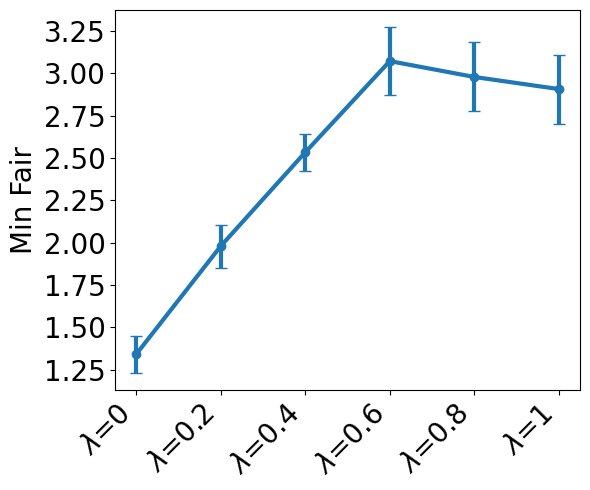

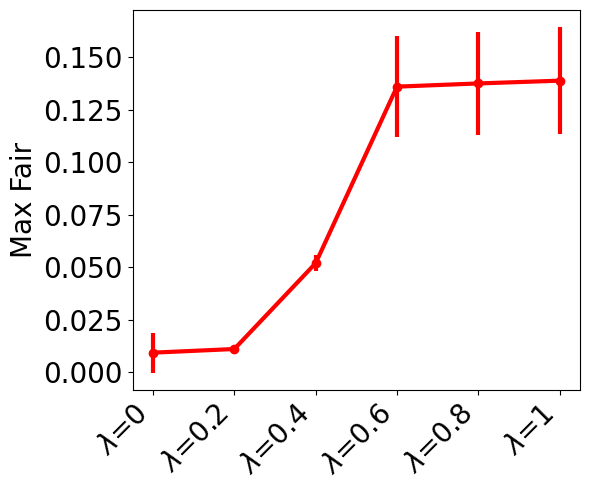

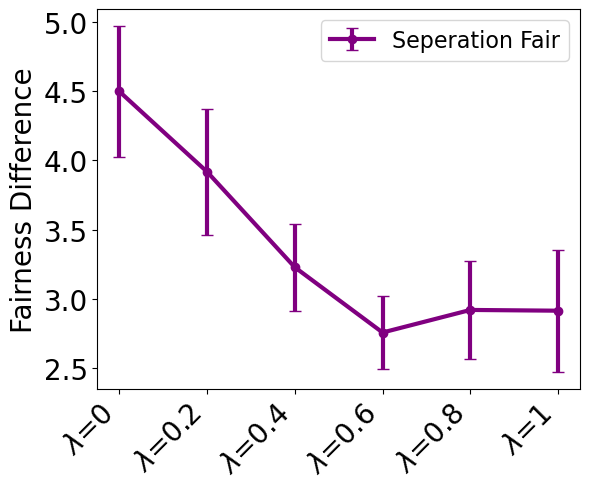

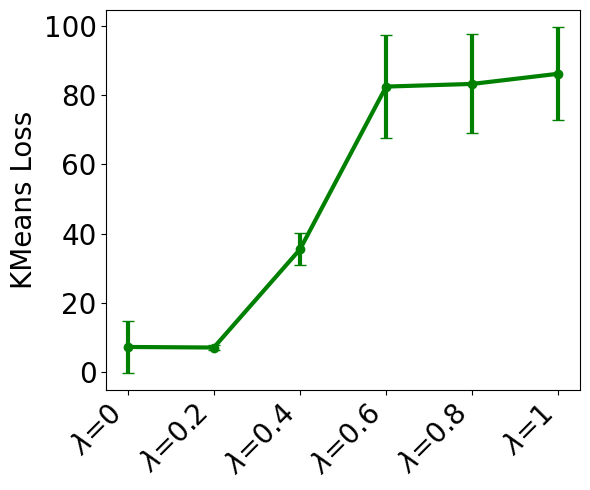

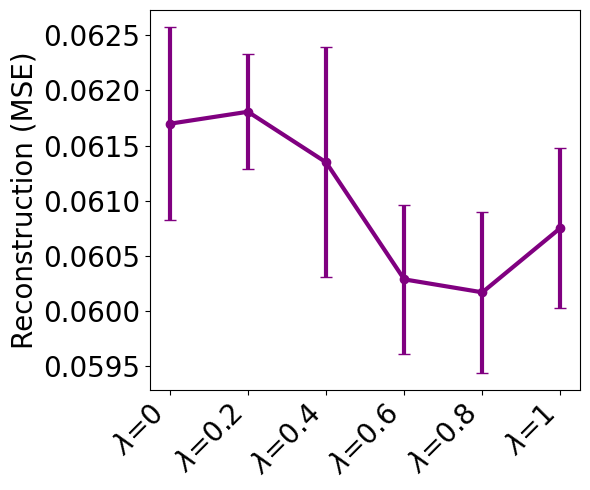

Plots saved in: ./plots


In [33]:


    
def plot_all_metrics_extended(min_fair_dict,
                              max_fair_dict,
                              social_fair_gap,
                              kmeans_costs_dict,
                              seperation_fair_gap,
                              rec_costs_dict=None,     # optional
                              cmp_costs_dict=None,     # optional
                              save_path="./plots"):
    
    """
    Plots mean ± std over seeds vs lambda in your exact style.
    Required: min_fair, fairness_gap, kmeans_costs dicts.
    Optional: reconstruction, compactness dicts (same structure).
    """
    def _to_numpy(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        if isinstance(x, (list, tuple)):
            if len(x) and isinstance(x[0], torch.Tensor):
                return np.stack([t.detach().cpu().numpy() for t in x])
            return np.asarray(x, dtype=float)
        return np.asarray(x, dtype=float)

    def _get_mean_std(metric_dict, lambda_list):
        means, stds = [], []
        for lam in lambda_list:
            arr = _to_numpy(metric_dict[lam])
            means.append(float(np.mean(arr)) if arr.size else 0.0)
            stds.append(float(np.std(arr, ddof=1)) if arr.size > 1 else 0.0)
        return means, stds
    
    def lam_label(l):
        s=f"{l:.2f}".rstrip('0').rstrip('.')
        return r'$\lambda$='+s
    
    lambda_list = sorted(min_fair_dict.keys())
    all_lams = sorted(lambda_list)
    tick_pos   = np.arange(1, 1 + len(all_lams))
    tick_labels = [lam_label(l) for l in all_lams]

    # ----- Min Fair -----
    min_fair_mean, min_fair_std = _get_mean_std(min_fair_dict, lambda_list)
    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, min_fair_mean, yerr=min_fair_std, fmt='-o', capsize=4, linewidth=3)
    plt.ylabel('Min Fair', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/min_fair_seperation.pdf", dpi=300)
    plt.show()

    # ---------- Plot 2: social term (max(LA,LB)) ----------
    max_fair_mean, max_fair_std = _get_mean_std(max_fair_dict, lambda_list)

    plt.figure(figsize=(6,5))
    plt.errorbar(tick_pos, max_fair_mean, yerr=max_fair_std,
                 marker='o', linewidth=3, color='red')
    plt.ylabel('Max Fair', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout(); 
    plt.savefig(f"{save_path}/max_fair_seperation.pdf", dpi=300); 
    plt.show()


    # ----- Fairness Gap -----
    social_gap_mean, social_gap_std = _get_mean_std(social_fair_gap, lambda_list)
    seperation_gap_mean, seperation_gap_std = _get_mean_std(seperation_fair_gap, lambda_list)

    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, seperation_gap_mean, yerr=seperation_gap_std, fmt='-o', capsize=4, color='purple', linewidth=3, label='Seperation Fair')

    plt.ylabel('Fairness Difference', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.legend(fontsize=16); 
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/fairness_gap_seperation.pdf", dpi=300)
    plt.show()

    # ----- KMeans Cost -----
    cost_mean, cost_std = _get_mean_std(kmeans_costs_dict, lambda_list)
    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, cost_mean, yerr=cost_std, fmt='-o', capsize=4, color='green', linewidth=3)
    plt.ylabel('KMeans Loss', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/kmeans_cost_seperation.pdf", dpi=300)
    plt.show()

    # ----- Reconstruction (optional) -----
    if rec_costs_dict is not None:
        rec_mean, rec_std = _get_mean_std(rec_costs_dict, lambda_list)
        plt.figure(figsize=(6, 5))
        plt.errorbar(tick_pos, rec_mean, yerr=rec_std, fmt='-o', capsize=4, color='purple', linewidth=3)
        plt.ylabel('Reconstruction (MSE)', fontsize=20)
        plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
        plt.yticks(fontsize=20)
        plt.tight_layout()
        plt.savefig(f"{save_path}/reconstruction_seperation.pdf", dpi=300)
        plt.show()

    print(f"Plots saved in: {save_path}")



# ===== Example usage with deep-run dicts =====
plot_all_metrics_extended(min_fair_dict,max_fair_dict,social_fair_gap, kmeans_costs,seperation_fair_gap,
                           rec_costs_dict=rec_costs, cmp_costs_dict=cmp_costs,
                           save_path="./plots")

